In [1]:
import os
import zipfile
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [4]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Membuat direktori jika belum ada
os.makedirs('/content/images', exist_ok=True)

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path = '/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')


In [6]:
list_hewan = os.listdir(dataset_dir)

# Mendefinisikan proporsi pembagian subset data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(list_hewan)

['monkey', 'chicken', 'swan', 'pig', 'cat', 'butterfly', 'elephant', 'duck', 'tiger', 'snake', 'horse', 'squirrel', 'rabbit', 'dragonfly', 'goat', 'cow', 'lion', 'dog', 'zebra', 'bee']


In [7]:
# Memilih secara acak file gambar untuk setiap kelas dan membaginya menjadi subset
for hewan in list_hewan:
    class_dir = os.path.join(dataset_dir, hewan)
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)

    train_count = int(len(image_files) * train_ratio)
    val_count = int(len(image_files) * val_ratio)
    test_count = len(image_files) - train_count - val_count

    train_files = image_files[:train_count]
    val_files = image_files[train_count:train_count + val_count]
    test_files = image_files[train_count + val_count:]

    # Memindahkan file gambar ke subset data train, validation, dan test
    for file_name in train_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(train_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file_name in val_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(val_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file_name in test_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(test_dir, hewan, file_name)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [8]:
# Membuat generator data dengan augmentasi
image_size = (256, 256)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8665 images belonging to 20 classes.
Found 1080 images belonging to 20 classes.
Found 1094 images belonging to 20 classes.


In [25]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# URL untuk mengunduh model InceptionV3 dari TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"


In [26]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
# Jumlah kelas output
num_classes = 20

# Load the pre-trained model
model = tf.keras.Sequential([
    hub.KerasLayer(model_url, trainable=False),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.build((None, 256, 256, 3))  # Memanggil build() dengan dimensi input yang sesuai
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                5140      
                                                                 
Total params: 22,332,468
Trainable params: 529,684
Non-trainable params: 21,802,784
_________________________________________________________________


In [28]:
# Melatih model dengan data train dan menggunakan data validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/50
270/270 [==============================] - 153s 546ms/step - loss: 0.5294 - accuracy: 0.8574 - val_loss: 0.1540 - val_accuracy: 0.9527
Epoch 2/50
270/270 [==============================] - 148s 546ms/step - loss: 0.3094 - accuracy: 0.9131 - val_loss: 0.1700 - val_accuracy: 0.9470
Epoch 3/50
270/270 [==============================] - 148s 547ms/step - loss: 0.2768 - accuracy: 0.9188 - val_loss: 0.1573 - val_accuracy: 0.9536
Epoch 4/50
270/270 [==============================] - 144s 535ms/step - loss: 0.2437 - accuracy: 0.9276 - val_loss: 0.1507 - val_accuracy: 0.9564
Epoch 5/50
270/270 [==============================] - 147s 544ms/step - loss: 0.2316 - accuracy: 0.9302 - val_loss: 0.1373 - val_accuracy: 0.9612
Epoch 6/50
270/270 [==============================] - 149s 552ms/step - loss: 0.2167 - accuracy: 0.9355 - val_loss: 0.1424 - val_accuracy: 0.9631
Epoch 7/50
270/270 [==============================] - 148s 546ms/step - loss: 0.2318 - accuracy: 0.9314 - val_loss: 0.1660 -

1/1 [==============================] - 1s 741ms/step


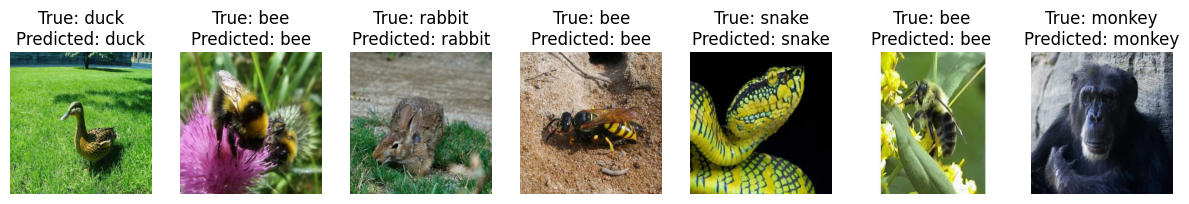

In [29]:
# Mengambil beberapa contoh gambar dari generator data test
num_examples = 7

# Mengambil batch gambar dan label
images, labels = next(test_generator)
  
# Mendapatkan nama kelas hewan
class_names = list(test_generator.class_indices.keys())

# Mengambil prediksi dari model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Menampilkan gambar dan labelnya
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    # Menampilkan gambar
    axes[i].imshow(images[i])
    axes[i].axis('off')

    # Menampilkan label sebenarnya dan label prediksi
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[predicted_labels[i]]
    axes[i].set_title(f'True: {true_label}\nPredicted: {predicted_label}')

plt.show()

In [30]:
# Evaluasi model dengan data test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

35/35 - 4s - loss: 0.1007 - accuracy: 0.9726 - 4s/epoch - 102ms/step
Test accuracy: 0.972577691078186


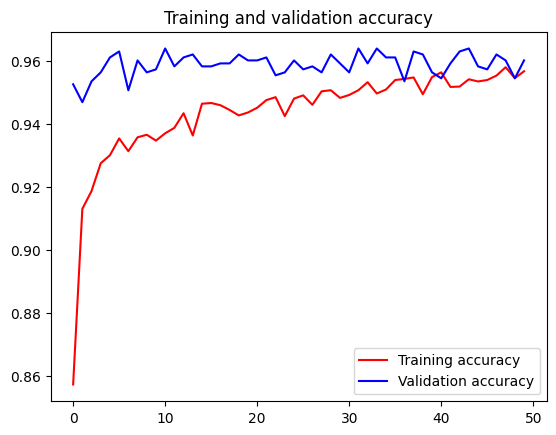

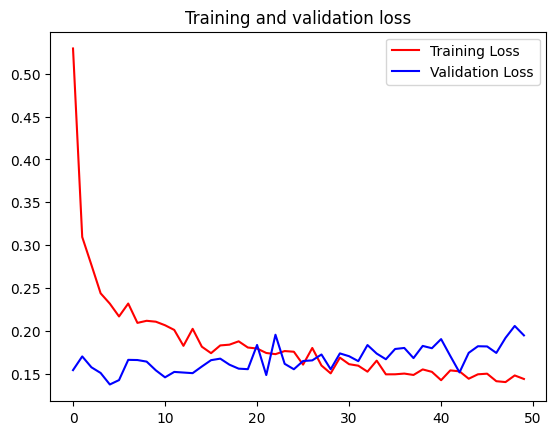

In [31]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

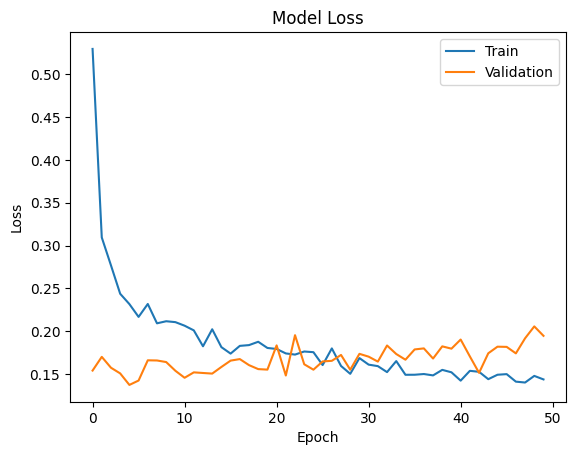

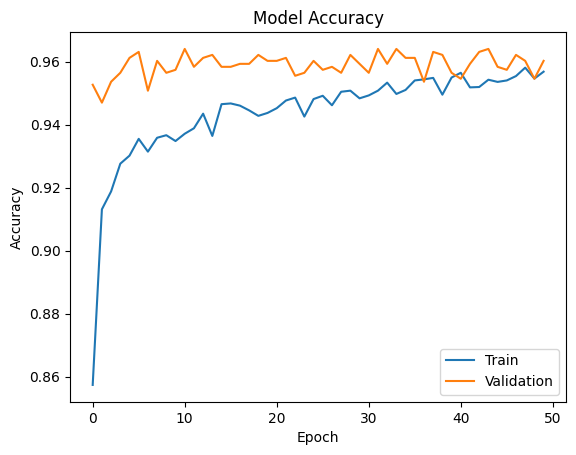

In [32]:
import matplotlib.pyplot as plt

  
# Plot kurva loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot kurva accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [33]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


35/35 [==============================] - 4s 105ms/step - loss: 0.1007 - accuracy: 0.9726
Test Loss: 0.10074951499700546
Test Accuracy: 0.972577691078186
